In [1]:
%pip install bioinfokit
# imports 
import numpy as np
import pandas as pd
from bioinfokit.visuz import general
from scipy import stats
from scipy.stats import levene
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.factorplots import interaction_plot
from bioinfokit.analys import stat
%pip install pingouin 
from pingouin import ancova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.power import TTestIndPower
from scipy.stats import ttest_ind
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
init_notebook_mode()


Processing ./.cache/pip/wheels/40/b8/82/23dd1b441e2c834181d4c595cff79f091212eb2c482e0550e2/bioinfokit-2.0.8-py3-none-any.whl
  Using cached textwrap3-0.9.2-py2.py3-none-any.whl (12 kB)
Processing ./.cache/pip/wheels/06/b2/e0/b239bd2c0ff89b98c4f0c86a63e7059f38a8dfaf6df2641c63/adjustText-0.7.3-py3-none-any.whl
  Created wheel for matplotlib-venn: filename=matplotlib_venn-0.11.7-py3-none-any.whl size=32153 sha256=f0a198d27b6ce61d2263c625426114ae4007d4a0c7547c6945392693a3273ec2
  Stored in directory: /home/jovyan/.cache/pip/wheels/fb/24/13/4c7b7f4121843c2fc7c5d6b4b1e3ab57be33428997761f996f
Successfully built matplotlib-venn
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
diabetes = pd.read_csv('diabetes (2).csv') # read the file

## Data Cleaning
### Replacing missing values 

In [11]:
# find the number of 0s in the BMI
count_BMI = (diabetes['BMI']==0).sum()
print('Count of zeros in BMI :', count_BMI)

Count of zeros in BMI : 11


In [12]:
# find the mean of the BMI 
(diabetes['BMI']).mean()

31.992578124999998

In [3]:
# replace the missing value in BMI with the mean of BMI 
diabetes.loc[(diabetes["BMI"]== 0), 'BMI'] = 32

In [4]:
# when BMI > 30, replace missing values with the mean of that attributes when BMI > 30
# when BMI < 30, replace missing values with the mean of that attributes when BMI < 30

for col in diabetes.columns[1:5]:
    mean_obesity = diabetes.loc[(diabetes[col] > 0) & (diabetes['BMI'] > 30),col].mean()
    mean_N_obesity = diabetes.loc[(diabetes[col] > 0) & (diabetes['BMI'] < 30),col].mean()
    diabetes.loc[(diabetes[col]== 0) & (diabetes['BMI'] > 30), col] = mean_obesity
    diabetes.loc[(diabetes[col]== 0) & (diabetes['BMI'] < 30), col] = mean_N_obesity
    print ('replacing 0s in {} when BMI > 30 with {}'.format(col,mean_obesity))
    print ('replacing 0s in {} when BMI < 30 with {}'.format(col,mean_N_obesity))
   
    
diabetes.head(10)
    

replacing 0s in Glucose when BMI > 30 with 126.37632135306553
replacing 0s in Glucose when BMI < 30 with 113.85512367491167
replacing 0s in BloodPressure when BMI > 30 with 74.45833333333333
replacing 0s in BloodPressure when BMI < 30 with 68.8974358974359
replacing 0s in SkinThickness when BMI > 30 with 33.45977011494253
replacing 0s in SkinThickness when BMI < 30 with 21.37037037037037
replacing 0s in Insulin when BMI > 30 with 176.64615384615385
replacing 0s in Insulin when BMI < 30 with 115.06106870229007


Pregnancies  Glucose  BloodPressure  SkinThickness     Insulin   BMI  \
0            6    148.0      72.000000       35.00000  176.646154  33.6   
1            1     85.0      66.000000       29.00000  115.061069  26.6   
2            8    183.0      64.000000       21.37037  115.061069  23.3   
3            1     89.0      66.000000       23.00000   94.000000  28.1   
4            0    137.0      40.000000       35.00000  168.000000  43.1   
5            5    116.0      74.000000       21.37037  115.061069  25.6   
6            3     78.0      50.000000       32.00000   88.000000  31.0   
7           10    115.0      74.458333       33.45977  176.646154  35.3   
8            2    197.0      70.000000       45.00000  543.000000  30.5   
9            8    125.0      96.000000       33.45977  176.646154  32.0   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
5                     0.201   30        0  
6                     0.248   26        1  
7                     0.134   29        0  
8                     0.158   53        1  
9                     0.232   54        1

## Data Visualization

### boxplot

<AxesSubplot:>

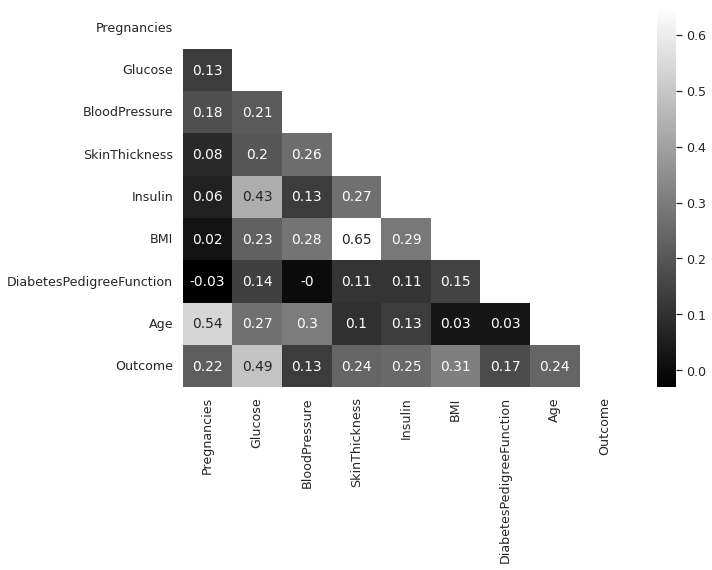

In [17]:
# Create a heat map for the dataset with the correlations shown 

corr=diabetes.corr().round(2)

sns.set(font_scale=1.15)
plt.figure(figsize=(10, 7))
sns.set_palette("bright")
sns.set_style("white")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,cmap='gist_yarg_r',mask=mask,cbar=True)

<AxesSubplot:>

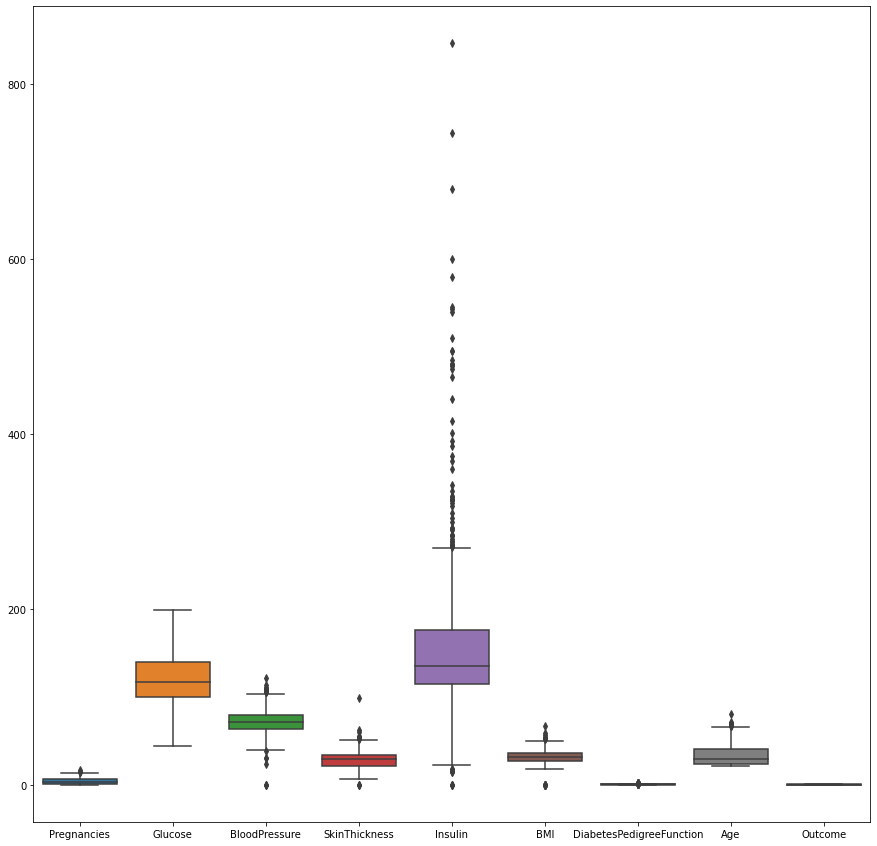

In [8]:
# create a box plot to show the distribution 

fig , ax = plt.subplots(figsize = (15, 15))
sns.boxplot(data = diabetes, ax = ax)

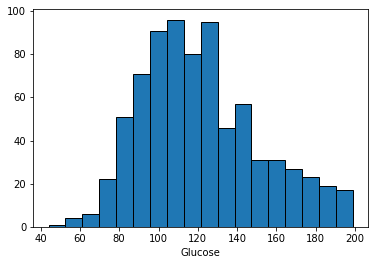

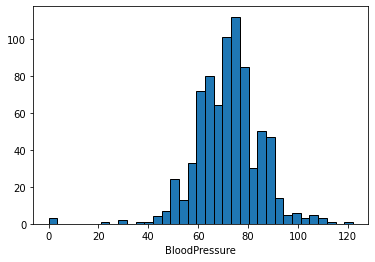

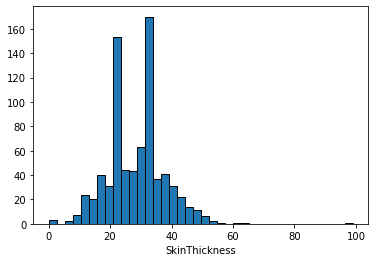

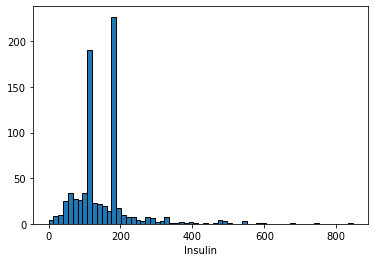

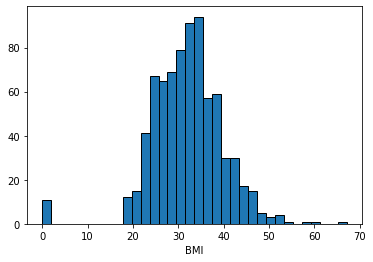

In [9]:
# create histograms for  to show the distribution 
for col in diabetes.columns[1:6]:
    plt.hist(diabetes[col],bins='auto', histtype='bar', ec= 'k')
    plt.xlabel(col)
    plt.show()

In [15]:
BMI_category = pd.cut(diabetes.BMI,bins=[-1,29.9,100],labels=['Not Obesity','Obesity'])
diabetes.insert(6, 'BMI_category', BMI_category)

# T-test

### A t-test can only be used when comparing the means of two groups (a.k.a. pairwise comparison).

### T-test assumes the two data are (approximately) normally distributed and have a similar amount of variance within each group being compared (a.k.a. homogeneity of variance).

### Groups are from the same population, therefore it is a paired t-test.

In [16]:
G_Obesity = diabetes.groupby('BMI_category').get_group("Obesity")
G_non_Obesity = diabetes.groupby('BMI_category').get_group("Not Obesity")

## Levene's test (Check for Homogeneity of Variance)




In [17]:
for col in diabetes.columns[1:5]:
    print(col,':')
    print(levene(G_Obesity[col],G_non_Obesity[col]))
    print('---'*30)

Glucose :
LeveneResult(statistic=15.163066460549606, pvalue=0.00010721766715945522)
------------------------------------------------------------------------------------------
BloodPressure :
LeveneResult(statistic=0.6698962116862035, pvalue=0.41334233517286634)
------------------------------------------------------------------------------------------
SkinThickness :
LeveneResult(statistic=13.636980844428399, pvalue=0.0002375224037251361)
------------------------------------------------------------------------------------------
Insulin :
LeveneResult(statistic=19.015278290635344, pvalue=1.474019751656397e-05)
------------------------------------------------------------------------------------------


 #### When the Null Hypothesis is non-significant (P-value > 0.05), there is no significant variance for Obesity group and non-Obesity group, and the equal variances are assumed

## Normality check

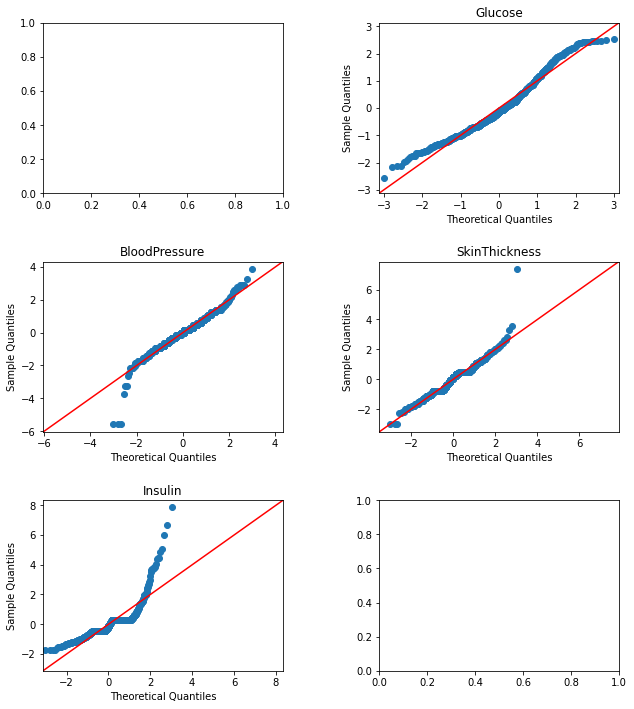

In [18]:
fig, axes = plt.subplots(nrows=3, ncols= 2, figsize=(10,10))
ax = axes.flatten()

for col in range(1,5):
    sm.qqplot(diabetes.iloc[:,col], line= '45',
    fit=True, dist=stats.norm, ax=ax[col])
    ax[col].set_title(diabetes.columns[col])

plt.subplots_adjust(left=0.1, bottom=0, right=0.9, top=0.9, wspace=0.4, hspace=0.4)    
plt.show()

### The Shapiro-Wilk test to check if continuous variables follow normal distributions

In [19]:

for col in diabetes.columns[1:5]:
    print(col)
    print(stats.shapiro(diabetes[col]))
    print('-'*90)

Glucose
ShapiroResult(statistic=0.9698880314826965, pvalue=1.7633769444636016e-11)
------------------------------------------------------------------------------------------
BloodPressure
ShapiroResult(statistic=0.958346962928772, pvalue=5.971687310228277e-14)
------------------------------------------------------------------------------------------
SkinThickness
ShapiroResult(statistic=0.9608185291290283, pvalue=1.8299225253582546e-13)
------------------------------------------------------------------------------------------
Insulin
ShapiroResult(statistic=0.7623881101608276, pvalue=7.839904324574758e-32)
------------------------------------------------------------------------------------------


## Actual T-test

In [21]:
#Fit data into the model
for col in diabetes.columns[1:5]:
    
    tStat, pValue = stats.ttest_ind(G_Obesity[col],G_non_Obesity[col], equal_var = False)
    print('{} has P-value:{} T-Statistic:{}'.format(col,pValue,tStat))
    print('---'*30)

Glucose has P-value:8.27060749144568e-09 T-Statistic:5.8363312655160335
------------------------------------------------------------------------------------------
BloodPressure has P-value:3.50638958119592e-08 T-Statistic:5.580846303364509
------------------------------------------------------------------------------------------
SkinThickness has P-value:1.3171961453160557e-86 T-Statistic:22.597263981006474
------------------------------------------------------------------------------------------
Insulin has P-value:3.0848362234952037e-25 T-Statistic:10.759129243187362
------------------------------------------------------------------------------------------


# Multiple Linear regression 

In [61]:
# multiple independent features
X = diabetes.iloc[:, 1:5].values
# dependent 
y = diabetes.iloc[:, 5].values


In [62]:
# splitting the dataset into the Training set and Test set 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fitting the dataset into the Training set and Test set 

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predicting the Test set results

y_pred = regressor.predict(X_test)



In [63]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

Actual  Predicted
0      42.9  40.408961
1      33.6  32.614189
2      34.0  33.416293
3      25.8  29.306360
4      24.6  28.544386
..      ...        ...
149    33.7  40.029047
150    27.8  27.468919
151    44.0  35.998772
152    26.3  26.371755
153    30.8  32.362819

[154 rows x 2 columns]

In [64]:
from sklearn.metrics import r2_score
score = r2_score(y_test,y_pred)
print(score)

0.39406356296244516


In [65]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 3.8892336753289203
Mean Squared Error: 24.292942209286313
Root Mean Squared Error: 4.928787093117973


In [69]:
print(regressor.score(X_train, y_train))

0.4586796098147433



# One way ANOVA

### The ANOVA test allows a comparison of more than two groups at the same time to determine whether a relationship exists between them

In [6]:
# Divided the Glucose into three groups - Normal (Glucose under 99), Impaired (Glucose between 99-125), likely_diabetic (Glucose between 125 - 300) 
# based on the  guideline provided by CDC 

Glucose_category = pd.cut(diabetes.Glucose,bins=[0,99,125,300],labels=['Normal','Impaired','likely_diabetic'])
diabetes.insert(2, 'Glucose_category', Glucose_category)

In [92]:
diabetes.head(10)

Pregnancies  Glucose Glucose_category  BloodPressure  SkinThickness  \
0            6    148.0  likely_diabetic      72.000000       35.00000   
1            1     85.0           Normal      66.000000       29.00000   
2            8    183.0  likely_diabetic      64.000000       21.37037   
3            1     89.0           Normal      66.000000       23.00000   
4            0    137.0  likely_diabetic      40.000000       35.00000   
5            5    116.0         Impaired      74.000000       21.37037   
6            3     78.0           Normal      50.000000       32.00000   
7           10    115.0         Impaired      74.458333       33.45977   
8            2    197.0  likely_diabetic      70.000000       45.00000   
9            8    125.0         Impaired      96.000000       33.45977   

      Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome  
0  176.646154  33.6                     0.627   50        1  
1  115.061069  26.6                     0.351   31        0  
2  115.061069  23.3                     0.672   32        1  
3   94.000000  28.1                     0.167   21        0  
4  168.000000  43.1                     2.288   33        1  
5  115.061069  25.6                     0.201   30        0  
6   88.000000  31.0                     0.248   26        1  
7  176.646154  35.3                     0.134   29        0  
8  543.000000  30.5                     0.158   53        1  
9  176.646154  32.0                     0.232   54        1

In [93]:
# precentage for each category 

diabetes['Glucose_category'].value_counts(normalize= True)


likely_diabetic    0.390625
Impaired           0.359375
Normal             0.250000
Name: Glucose_category, dtype: float64

## Box plot display to compare the means and variability of Glucose
#### Research Question :Is the mean Glucose Level the same for Underweight, Healthy Weight, Overweight, and Obesity populations

<function matplotlib.pyplot.show(close=None, block=None)>

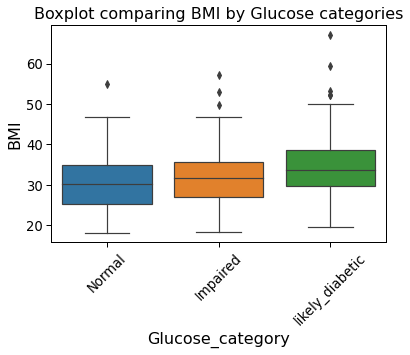

In [94]:
# create a box plot
sns.set_context('paper', font_scale=1.5, rc={'font.size':16, 'axes.titlesize':16, 'axes.labelsize':16})
plt.title('Boxplot comparing BMI by Glucose categories')
sns.boxplot(x='Glucose_category', y = 'BMI', data=diabetes)
plt.xlabel('Glucose_category')
plt.ylabel('BMI')
plt.xticks(rotation=45)
plt.show


In [95]:
# Fit the ANOVA model to data
model = smf.ols('BMI ~ Glucose_category', data = diabetes).fit()
aov_table= sm.stats.anova_lm(model, typ = 2)
print(aov_table)

                        sum_sq     df          F        PR(>F)
Glucose_category   1952.071212    2.0  21.765851  6.402894e-10
Residual          34304.528150  765.0        NaN           NaN


The result is significant (there is a significant differece between BMI categories)

In [96]:
# post hoc corrections (Bonferroni)
pair_t = model.t_test_pairwise('Glucose_category')
pair_t.result_frame

coef   std err         t         P>|t|  \
Impaired-Normal           1.381839  0.629307  2.195809  2.840514e-02   
likely_diabetic-Normal    3.896375  0.618894  6.295706  5.153842e-10   
likely_diabetic-Impaired  2.514536  0.558523  4.502117  7.776075e-06   

                          Conf. Int. Low  Conf. Int. Upp.     pvalue-hs  \
Impaired-Normal                 0.146465         2.617213  2.840514e-02   
likely_diabetic-Normal          2.681443         5.111307  1.546153e-09   
likely_diabetic-Impaired        1.418117         3.610956  1.555209e-05   

                          reject-hs  
Impaired-Normal                True  
likely_diabetic-Normal         True  
likely_diabetic-Impaired       True

# Two Way Anova ( BMI, BloodPressure and SkinThickness)

### Turn BloodPressure into categorical values

In [22]:
# Divided the BloodPressure into three groups - Normal (BloodPressure under 80), Impaired (BloodPressure between 80-90), likely_diabetic (BloodPressure between 90 - 130) 
# based on the  guideline provided by CDC 
BloodPressure_category = pd.cut(diabetes.BloodPressure,bins=[0,80,90,130],labels=['Normal','Stage 1','stage 2'])
diabetes.insert(4, 'BloodPressure_category', BloodPressure_category)

In [23]:
diabetes['BloodPressure_category'].value_counts(normalize= True)

Normal     0.784314
Stage 1    0.166013
stage 2    0.049673
Name: BloodPressure_category, dtype: float64

### Turn SkinThickness into categorical values

In [24]:
# find 25, 50, 75 percentile values of SkinThinkness
SkinThickness_25th = diabetes.SkinThickness.quantile(0.25)
SkinThickness_50th = diabetes.SkinThickness.quantile(0.5)
SkinThickness_75th = diabetes.SkinThickness.quantile(0.75)
print('The 25th percentile of SkinThickness is', SkinThickness_25th)
print('The 50th percentile of SkinThickness is', SkinThickness_50th)
print('The 75th percentile of SkinThickness is', SkinThickness_75th)

The 25th percentile of SkinThickness is 21.37037037037037
The 50th percentile of SkinThickness is 30.0
The 75th percentile of SkinThickness is 33.45977011494253


In [25]:
SkinThickness_category = pd.cut(diabetes.SkinThickness,bins=[0,21.37,33.45,100],labels=['thin','median','thick'])
diabetes.insert(6, 'SkinThickness_category', SkinThickness_category)

In [27]:
diabetes['SkinThickness_category'].value_counts(normalize= True)

median    0.437908
thick     0.386928
thin      0.175163
Name: SkinThickness_category, dtype: float64

<AxesSubplot:xlabel='BloodPressure_category', ylabel='BMI'>

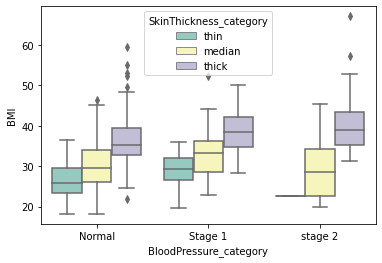

In [28]:
sns.boxplot(x="BloodPressure_category", y="BMI", hue="SkinThickness_category", data=diabetes, palette="Set3")

<AxesSubplot:xlabel='SkinThickness_category', ylabel='BMI'>

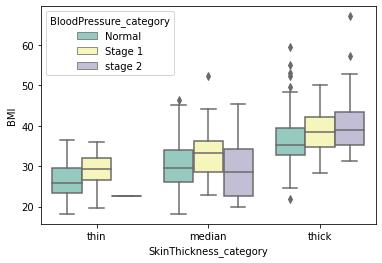

In [18]:
sns.boxplot(x="SkinThickness_category", y="BMI", hue="BloodPressure_category", data=diabetes, palette="Set3")

In [60]:
#doing the 2 way anova with bioinfokit

res = stat()
res.anova_stat(df=diabetes, res_var='BMI', anova_model='BMI ~ C(BloodPressure_category) + C(SkinThickness_category) + C(SkinThickness_category):C(BloodPressure_category)')
res.anova_summary

df        sum_sq  \
C(BloodPressure_category)                             2.0    813.946704   
C(SkinThickness_category)                             2.0  11519.039081   
C(SkinThickness_category):C(BloodPressure_categ...    4.0    276.378774   
Residual                                            756.0  22468.552985   

                                                        mean_sq           F  \
C(BloodPressure_category)                            406.973352   13.693443   
C(SkinThickness_category)                           5759.519540  193.790707   
C(SkinThickness_category):C(BloodPressure_categ...    69.094694    2.324831   
Residual                                              29.720308         NaN   

                                                          PR(>F)  
C(BloodPressure_category)                           1.439456e-06  
C(SkinThickness_category)                           1.138359e-68  
C(SkinThickness_category):C(BloodPressure_categ...  5.503685e-02  
Residual                                                     NaN

In [29]:
#post hoc test for main effect of BloodPressure_category
res = stat()
res.tukey_hsd(df=diabetes, res_var='BMI', xfac_var='BloodPressure_category', anova_model='BMI ~ C(SkinThickness_category) + C(BloodPressure_category) + C(SkinThickness_category):C(BloodPressure_category)')
res.tukey_summary

/opt/conda/lib/python3.8/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


group1   group2      Diff     Lower     Upper   q-value  p-value
0   Normal  stage 2  5.111702  2.970093  7.253311  7.927038  0.00100
1   Normal  Stage 1  3.439136  2.188627  4.689646  9.133727  0.00100
2  stage 2  Stage 1  1.672565 -0.694693  4.039823  2.346514  0.22201

In [30]:
#post hoc test for main effect of SkinThickness_category

res.tukey_hsd(df=diabetes, res_var='BMI', xfac_var='SkinThickness_category', anova_model='BMI ~ C(SkinThickness_category) + C(BloodPressure_category) + C(SkinThickness_category):C(BloodPressure_category)')
res.tukey_summary

/opt/conda/lib/python3.8/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


group1  group2       Diff     Lower      Upper    q-value  p-value
0   thick  median   6.764358  5.743080   7.785635  21.997255    0.001
1   thick    thin  10.638387  9.305378  11.971397  26.505022    0.001
2  median    thin   3.874030  2.565424   5.182636   9.831951    0.001

In [31]:
#post hoc test for all the possible groups combination 

res.tukey_hsd(df=diabetes, res_var='BMI', xfac_var=['SkinThickness_category','BloodPressure_category'], anova_model='BMI ~ C(SkinThickness_category) + C(BloodPressure_category) + C(SkinThickness_category):C(BloodPressure_category)')
res.tukey_summary.head()

/opt/conda/lib/python3.8/site-packages/bioinfokit/analys.py:368: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[(ele1, ele2)] = df[(df[xfac_var[0]] == ele1) &


group1             group2      Diff     Lower      Upper  \
0  (thick, Normal)   (thick, stage 2)  4.587776  0.934497   8.241056   
1  (thick, Normal)   (thick, Stage 1)  1.970632 -0.494693   4.435957   
2  (thick, Normal)   (median, Normal)  6.401535  4.850704   7.952366   
3  (thick, Normal)  (median, stage 2)  6.708057  1.861794  11.554320   
4  (thick, Normal)  (median, Stage 1)  3.290666  0.531090   6.050241   

     q-value   p-value  
0   5.524634  0.003260  
1   3.516539  0.239873  
2  18.159495  0.001000  
3   6.089393  0.001000  
4   5.245968  0.006869

## ANCOVA 
### Assumption of ANCOVA
#### 1. Normality 2. Homogeneity of variance 3. The covarite and dependent variable is linearly related as each level of independent variable 

Text(0.5, 20.80000000000002, 'SkinThickness')

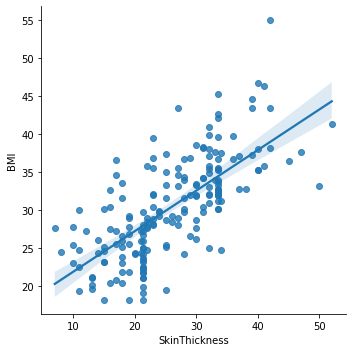

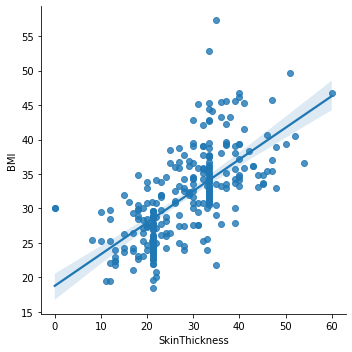

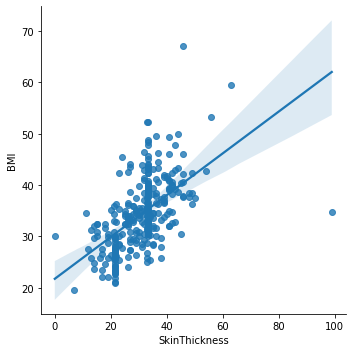

In [7]:
# check if the covarite and dependent variable is linearly related as each level of independent variable
G_Normal = diabetes.groupby('Glucose_category').get_group("Normal")
G_Impaired = diabetes.groupby('Glucose_category').get_group("Impaired")
G_likely_diabetic = diabetes.groupby('Glucose_category').get_group("likely_diabetic")

sns.lmplot(x="SkinThickness", y="BMI", data=G_Normal, order=1)
plt.ylabel('BMI')
plt.xlabel('SkinThickness')

sns.lmplot(x="SkinThickness", y="BMI", data=G_Impaired, order=1)
plt.ylabel('BMI')
plt.xlabel('SkinThickness')

sns.lmplot(x="SkinThickness", y="BMI", data=G_likely_diabetic, order=1)
plt.ylabel('BMI')
plt.xlabel('SkinThickness')

In [8]:
#perform ANCOVA
reg = ols('BMI~Glucose_category + SkinThickness', data=diabetes).fit() # BMI- dependent / Glucose - independent 
avo = sm.stats.anova_lm(reg,type=2)
print(avo)

                     df        sum_sq       mean_sq           F        PR(>F)
Glucose_category    2.0   1952.071212    976.035606   36.289366  8.791400e-16
SkinThickness       1.0  13756.050950  13756.050950  511.455074  4.319236e-87
Residual          764.0  20548.477200     26.895913         NaN           NaN


#### At 5% of level significant, the glucose_category has a statistical significant effect on the mean BMI

## Post-Hoc comparison using the 2k HSV test

In [9]:
mc = pairwise_tukeyhsd(diabetes['BMI'], diabetes['Glucose_category'], alpha=0.05)
print(mc)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
 group1       group2     meandiff p-adj   lower  upper  reject
--------------------------------------------------------------
Impaired          Normal  -1.3818 0.0725 -2.8596  0.096  False
Impaired likely_diabetic   2.5145    0.0   1.203 3.8261   True
  Normal likely_diabetic   3.8964    0.0   2.443 5.3497   True
--------------------------------------------------------------


# Power analysis 

In [10]:
# parameters for the analysis 

effect_size = 0.8  # Cohen's D of at least 0.8
alpha = 0.05 # significant level 
power = 0.8 

# perform power analysis 
power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size = effect_size, 
                                         power = power, 
                                         alpha = alpha)

print ('Required sample size: {0:.2f}'.format (sample_size))

Required sample size: 25.52


### Further explore the power curves

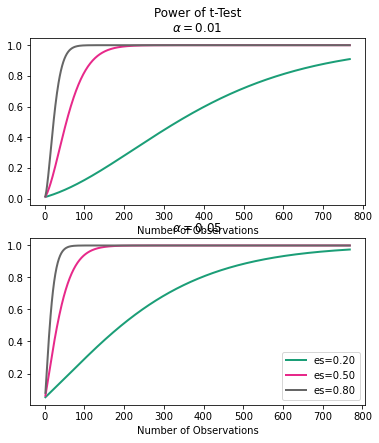

In [12]:
# power vs. number of observations 

fig = plt.figure()
ax = fig.add_subplot(2,1,1)
fig = TTestIndPower().plot_power(dep_var='nobs',
                                 nobs= np.arange(2, 768),
                                 effect_size=np.array([0.2, 0.5, 0.8]),
                                 alpha=0.01,
                                 ax=ax, title='Power of t-Test' + '\n' + r'$\alpha = 0.01$')
ax.get_legend().remove()
ax = fig.add_subplot(2,1,2)
fig = TTestIndPower().plot_power(dep_var='nobs',
                                 nobs= np.arange(2, 769),
                                 effect_size=np.array([0.2, 0.5, 0.8]),
                                 alpha=0.05,
                                 ax=ax, title=r'$\alpha = 0.05$') 
fig.subplots_adjust(top = 1.4)